Epoch 1/50
391/391 - 1s - loss: 4.1548 - accuracy: 0.0745 - val_loss: 3.8874 - val_accuracy: 0.1090 - 891ms/epoch - 2ms/step
Epoch 2/50
391/391 - 1s - loss: 3.7517 - accuracy: 0.1350 - val_loss: 3.6889 - val_accuracy: 0.1460 - 633ms/epoch - 2ms/step
Epoch 3/50
391/391 - 1s - loss: 3.5798 - accuracy: 0.1657 - val_loss: 3.5785 - val_accuracy: 0.1697 - 674ms/epoch - 2ms/step
Epoch 4/50
391/391 - 1s - loss: 3.4646 - accuracy: 0.1866 - val_loss: 3.5178 - val_accuracy: 0.1771 - 630ms/epoch - 2ms/step
Epoch 5/50
391/391 - 1s - loss: 3.3697 - accuracy: 0.2022 - val_loss: 3.4589 - val_accuracy: 0.1887 - 632ms/epoch - 2ms/step
Epoch 6/50
391/391 - 1s - loss: 3.2815 - accuracy: 0.2191 - val_loss: 3.3900 - val_accuracy: 0.2016 - 619ms/epoch - 2ms/step
Epoch 7/50
391/391 - 1s - loss: 3.2050 - accuracy: 0.2330 - val_loss: 3.3399 - val_accuracy: 0.2147 - 617ms/epoch - 2ms/step
Epoch 8/50
391/391 - 1s - loss: 3.1393 - accuracy: 0.2452 - val_loss: 3.2869 - val_accuracy: 0.2217 - 617ms/epoch - 2ms/step


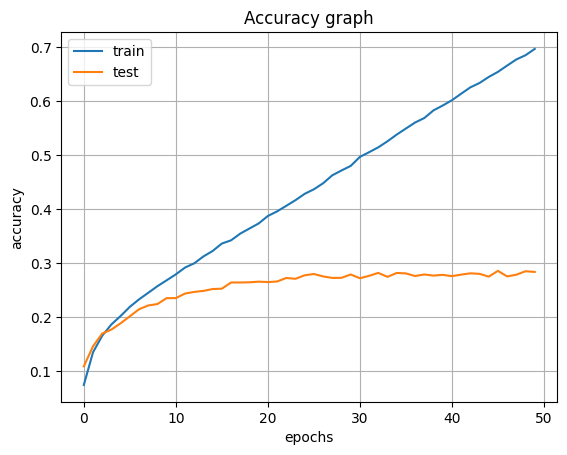

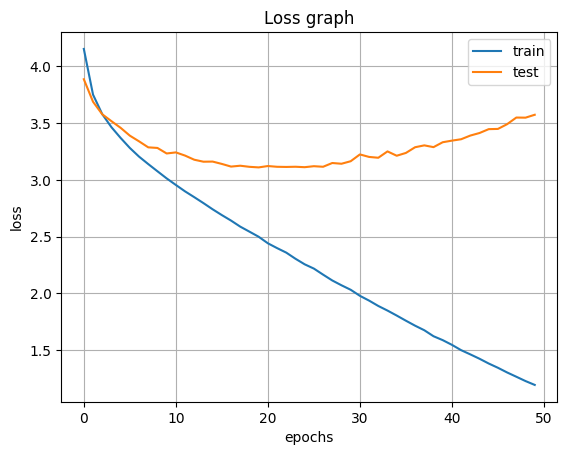

In [14]:
# 09
import numpy as np
import tensorflow as tf
import tensorflow.keras.datasets as ds
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# CIFAR-10 데이터셋 불러오기 (훈련/테스트 세트)
(x_train, y_train), (x_test, y_test) = ds.cifar100.load_data()

# CIFAR-10 이미지(32x32x3)를 1차원 벡터(3072)로 reshape
x_train = x_train.reshape(50000, 3072)
x_test = x_test.reshape(10000, 3072)

# 데이터 타입을 float32로 변환하고 0~1로 정규화
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# 레이블을 One-hot 인코딩으로 변환 (10개 클래스)
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# 다층 퍼셉트론(MLP) 모델 정의
dmlp = Sequential()
dmlp.add(Dense(units=1024, activation='relu', input_shape=(3072,)))  # 입력층 -> 은닉층(1024)
dmlp.add(Dense(units=512, activation='relu'))                        # 은닉층(512)
dmlp.add(Dense(units=512, activation='relu'))                        # 은닉층(512)
dmlp.add(Dense(units=100, activation='softmax'))                      # 출력층(10), softmax로 확률 출력

# 모델 컴파일
# 손실 함수: categorical_crossentropy (다중 클래스 분류)
# 옵티마이저: Adam (learning_rate=0.0001)
# 평가 지표: 정확도(accuracy)
dmlp.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# 모델 학습
# 배치 크기: 128
# 에폭: 50
# 검증 데이터: x_test, y_test
hist = dmlp.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=2
)

# 테스트 데이터로 최종 정확도 출력
print('정확률 =', dmlp.evaluate(x_test, y_test, verbose=0)[1] * 100)

# 학습된 모델 저장 (주석 처리되어 있음)
# dmlp.save('dmlp_trained.h5')

# 학습 정확도 및 검증 정확도 그래프 출력
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

# 학습 손실 및 검증 손실 그래프 출력
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import winsound

# [1] 학습된 DMLP(다층 퍼셉트론) 모델 불러오기
model = tf.keras.models.load_model('dmlp_trained.h5')

# [2] 쓰기 영역 초기화 함수
def reset():
    global img

    # 200x520 흰색 캔버스
    img = np.ones((200, 520, 3), dtype=np.uint8) * 255

    # 숫자 5개 쓸 수 있는 빨간색 사각형 칸 그리기
    for i in range(5):
        cv.rectangle(img, (10 + i * 100, 50), (10 + (i + 1) * 100, 150), (0, 0, 255))

    # 단축키 안내 텍스트
    cv.putText(img, 'e:erase s:show r:recognition q:quit',
               (10, 40), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1)

# [3] 사각형 안에 쓴 숫자들을 가져와 전처리하는 함수
def grab_numerals():
    numerals = []
    for i in range(5):
        # 각 사각형 영역(ROI) 자르기, 파랑 채널 사용
        roi = img[51:149, 11 + i * 100 : 9 + (i + 1) * 100, 0]

        # 색상 반전(흰 배경 → MNIST 형태)
        roi = 255 - cv.resize(roi, (28, 28), interpolation=cv.INTER_CUBIC)

        numerals.append(roi)

    numerals = np.array(numerals)
    return numerals

# [4] 전처리된 숫자들 시각화 (Matplotlib 사용)
def show():
    numerals = grab_numerals()
    plt.figure(figsize=(25, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(numerals[i], cmap='gray')
        plt.xticks([]); plt.yticks([])
    plt.show()

# [5] 신경망 모델로 숫자 인식 후 결과 출력
def recognition():
    numerals = grab_numerals()

    # (5, 28, 28) → (5, 784)로 reshape, 0~1로 정규화
    numerals = numerals.reshape(5, 784)
    numerals = numerals.astype(np.float32) / 255.0

    # 모델 예측 (5개 숫자 각각)
    res = model.predict(numerals)

    # 가장 확률 높은 순으로 정렬된 인덱스 가져오기
    class_ids = np.argsort(res, axis=1)[:, ::-1]  # 내림차순 정렬

    # 원본 이미지에 인식 결과 텍스트로 표시 (1순위 + (2순위))
    for i in range(5):
        first = class_ids[i][0]   # 1순위
        second = class_ids[i][1]  # 2순위
        text = f'{first}({second})'
        cv.putText(img, text,
                   (40 + i * 100, 180),  # 위치는 살짝 조정해도 OK
                   cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)

    # 예측 후 경고음 출력
    winsound.Beep(1000, 500)

# [6] 붓 크기와 색상 설정 (검정색)
BrushSiz = 4
LColor = (0, 0, 0)

# [7] 마우스 콜백: 마우스로 숫자 쓰기
def writing(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(img, (x, y), BrushSiz, LColor, -1)
    elif event == cv.EVENT_MOUSEMOVE and flags == cv.EVENT_FLAG_LBUTTON:
        cv.circle(img, (x, y), BrushSiz, LColor, -1)

# [8] 윈도우 초기화 & 마우스 콜백 등록
reset()
cv.namedWindow('Writing')
cv.setMouseCallback('Writing', writing)

# [9] GUI 루프: 단축키로 erase/show/recognition/quit
while True:
    cv.imshow('Writing', img)
    key = cv.waitKey(1)
    if key == ord('e'):
        reset()
    elif key == ord('s'):
        show()
    elif key == ord('r'):
        recognition()
    elif key == ord('q'):
        break

cv.destroyAllWindows()